Python Notebook for chromatogram denoising using k-nearest neighbour algorithm with chromatogram segmentation

Necessary libraries

In [1]:
import numpy as np
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import matplotlib.pyplot as plt
import sklearn
import scipy
from sklearn import neighbors
import math
from itertools import islice
from joblib import Parallel, delayed
import statistics


Used functions

In [2]:
#open excel
# extract first column as time and second as signal
# file (string) = path to excel file
# sheet (string) = name of excel sheet
def open_chrom_xlsx(file, sheet):
    if type(file) != str:
        print("path must be a string")
    if type(sheet) != str:
        print("sheet must be a string")
    df = pd.read_excel(file, sheet_name= sheet)
    df.columns=(['time','abs'])
    time = list(df['time'])
    abs = list(df['abs'])
    return time,abs

#compute mean of a list
# l (list) = numerical list (len > 0)
def mean(l):
    if len(l) < 1:
        print("list must have length higher than 0")
    else:
        s = sum(l)
        l = len(l)
        avr = s/l
    return avr

# k-nearest neighbors
# x (list) = time axis or number of datapoints
# y (list) = signal
# n_neighbors (odd int) = number of neighbors (must be odd)
def knearestneighbor(n_neighbors,x,y):
    if n_neighbors < 1 or n_neighbors%2 == 0:
        print("number of neighbors must be a positive odd integer value")
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights="uniform")
    pred = knn.fit(x, y).predict(x)
    return pred

# Durbin Watson criterion
#expLine (list) = experimental signal
#smtLine (list) = denoised line
def DWcrit(expLine,smtLine):
    if len(expLine) != len(smtLine):
        print("experimental and smoothened signal must have same length")
    num = 0
    denum = 0
    for i in range(len(expLine)):
        denum = denum + (expLine[i]-smtLine[i])**2
    for j in range(len(expLine)-1):
        num = num + ((expLine[j+1]-smtLine[j+1])-(expLine[j]-smtLine[j]))**2
    DW = num/denum
    fac = len(expLine) / (len(expLine) - 1)
    DWfac = DW * fac
    return DWfac

# segment signal in groups of n
# l = signal
# n = number of elements in segment
def chunk(l, n):
    if type(n) != int or n < 1:
        print("number of elements must be a positve integer higher than 1")
    n = max(1, n)
    return list((l[i:i+n] for i in range(0, len(l), n)))

# group segments together to form peak blocks and inter-peak blocks
# seg (list of lists) = list of lists storing signal segmented into groups
# thresh (float) = threshold used to classify segment as peak or inter-peak segment
def grouping(seg,thresh):
    groups = []
    while len(seg) > 1:
        i = 0
        init = seg[i]
        block = []
        block.append(init)
        if mean(init) <= thresh:
            while mean(seg[i+1]) <= thresh:
                block.append(seg[i + 1])
                if i + 1 == len(seg)-1:
                    break
                else:
                    i = i + 1

        if mean(init) > thresh:
            while mean(seg[i+1])>thresh:
                block.append(seg[i + 1])
                if i + 1 == len(seg) - 1:
                    break
                else:
                    i = i + 1
        lst = [x for l in block for x in l]
        groups.append(lst)
        seg = seg[i+1:]

    return groups

# smoothing of inter section
# groups (list of lists) = list of lists storing the peak and inter-peak segments
def smooth_inter(groups):
    for i in range(len(groups)-1):
        n = min(3,min(int(len(groups[i])/3),int(len(groups[i+1])/3)))
        last = groups[i][-n:].tolist()
        first = groups[i+1][:n].tolist()
        last.extend(first)
        x = np.linspace(0,1,len(last))
        #pred = polyreg(x,last,2)
        # if len(last)%2 != 0:
        #     nei = len(last)
        # else:
        #     nei = len(last) - 1
        pred = knearestneighbor(3,np.transpose([np.linspace(0, 1, len(last))]),last)
        groups[i][-n:] = pred[:n]
        groups[i + 1][:n] = pred[-n:]

    return groups

# function to find optimal smoothing using k-nearest neighbour
# segment (list) = signal segment that needs to be optimally smoothened
# thresh (float) = threshold classifying segment as peak or inter-peak segment
def segment_smooth_knearest(segment,thresh):
    DW_crit = []
    initial = 0
    if mean(segment) < thresh:
        if int(len(segment)/10)%2 == 0:
            initial = int(len(segment)/10) + 1
        else :
            initial = int(len(segment)/10)
        if len(segment) > 500:
            nei = np.arange(initial,len(segment),50)
        else:
            nei = np.arange(initial,len(segment),10)
        for n in nei:
            p = knearestneighbor(n, np.transpose([np.linspace(0, 1, len(segment))]), segment)
            crit = (2.0 - DWcrit(segment, p)) ** 2
            DW_crit.append(crit)
    else:
        initial = 5
        nei = np.arange(initial, int(len(segment)/3), 2)
        for n in nei:
            p = knearestneighbor(n, np.transpose([np.linspace(0, 1, len(segment))]), segment)
            crit = (2.0 - DWcrit(segment, p)) ** 2
            DW_crit.append(crit)
    if (len(DW_crit) == 0):
        smooth = knearestneighbor(int(len(segment)/4), np.transpose([np.linspace(0, 1, len(segment))]), segment)
    else:
        val, idx = min((val, idx) for (idx, val) in enumerate(DW_crit))
        smooth = knearestneighbor(nei[idx], np.transpose([np.linspace(0, 1, len(segment))]), segment)

    return smooth

#computes baseline of signal
# func (list) = signal
def baseline(func):
    l = []
    for i in range(len(func)-2):
        m = (math.fabs(func[i+1]-func[i]) + math.fabs(func[i+1] - func[i+2])) / 2
        l.append(m)
    med = statistics.median(l)
    return med

Application of KNN on experimental chromatogram

In [3]:
c_noisy = np.load("./constructed7.npy")

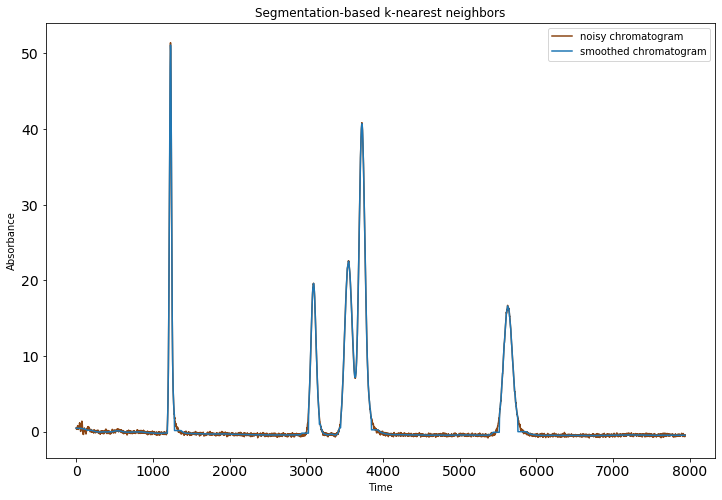

In [8]:
## segmentation
seg = chunk(c_noisy,10)
## grouping ##
groups = grouping(seg, max(c_noisy)/25)

####################
#k-nearest neighbor#
####################

smoothing = Parallel(n_jobs=3)(delayed(segment_smooth_knearest)(g,max(c_noisy)/25) for g in groups)
lst = [x for l in smoothing for x in l]
groups = smooth_inter(smoothing)
lst = [x for l in groups for x in l]

plt.figure(figsize=(12,8))
plt.plot(c_noisy, color = "saddlebrown")
plt.plot(lst)
plt.title("Segmentation-based k-nearest neighbors")
plt.legend(("noisy chromatogram","smoothed chromatogram"))
plt.ylabel("Absorbance")
plt.xlabel("Time")
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.show()

save smoothened chromatogram as excel file (xlsx)

In [6]:
df = pd.DataFrame(lst)
df.to_excel(excel_writer="./KNN_denoised_chrom.xlsx")